# Project: Prediction of Used Cars Prices

Dillon Constantine - dillon.l.constantine@aib.ie

This Project uses various modeling methods to predict the price of used cars.

## Package Import

In [1]:
# Data Analysis Packages
import pandas as pd
import numpy as np

# Plotting / Visualisation Packages
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling Packages
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import re

## Dataset Import & First look

In [2]:
# Imports a csv file making the first row of the csv the index column.
used_cars_df = pd.read_csv("originalData.csv", index_col = 'Unnamed: 0')

# Show a sample of the data, 5 rows specified.
used_cars_df.head(5)

,Year,Make,Model,Kilometres,Body Type,Engine,Transmission,Drivetrain,Exterior Colour,Interior Colour,Passengers,Doors,Fuel Type,City,Highway,Price
0,2019,Acura,MDX,53052 km,SUV,V6 Cylinder Engine,9 Speed Automatic,AWD,Majestic Black Pearl,Red,NaN,NaN,Gas,12.2L/100km,9.0L - 9.5L/100km,43880
1,2018,Acura,MDX,77127 km,SUV,V6 Cylinder Engine,9 Speed Automatic,AWD,Modern Steel Metallic,Black,NaN,NaN,Gas,12.6L/100km,9.0L/100km,36486
2,2019,Acura,RDX,33032 km,SUV,2.0L 4cyl,10 Speed Automatic,AWD,White Diamond Pearl,Black,5.0,4,Premium Unleaded,11.0L/100km,8.6L/100km,40888
3,2020,Acura,RDX,50702 km,SUV,4 Cylinder Engine,NaN,AWD,Platinum White Pearl,Black,NaN,NaN,Gas,11.0L/100km,8.6L/100km,44599
4,2021,Acura,RDX,67950 km,SUV,4 Cylinder Engine,NaN,AWD,Apex Blue Pearl,Red,NaN,NaN,Gas,11.3L/100km,9.1L/100km,46989


In [3]:
# Establish the number of rows and columns in the data.

# Display the shape of the DataFrame
print("Shape:", used_cars_df.shape)

# Display column names
print("Columns:", used_cars_df.columns)

Shape: (24198, 16)
Columns: Index(['Year', 'Make', 'Model', 'Kilometres', 'Body Type', ' Engine',
       ' Transmission', ' Drivetrain', ' Exterior Colour', ' Interior Colour',
       ' Passengers', ' Doors', ' Fuel Type', ' City', ' Highway', 'Price'],
      dtype='object')


In [4]:
# Used to strip the Whitespace at the begining and end of the headers
used_cars_df.columns = used_cars_df.columns.str.strip()

used_cars_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24198 entries, 0 to 24197
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Year             24198 non-null  int64  
 1   Make             24198 non-null  object 
 2   Model            24198 non-null  object 
 3   Kilometres       23965 non-null  object 
 4   Body Type        22968 non-null  object 
 5   Engine           22136 non-null  object 
 6   Transmission     22854 non-null  object 
 7   Drivetrain       22967 non-null  object 
 8   Exterior Colour  23182 non-null  object 
 9   Interior Colour  16418 non-null  object 
 10  Passengers       12025 non-null  float64
 11  Doors            19611 non-null  object 
 12  Fuel Type        23464 non-null  object 
 13  City             17835 non-null  object 
 14  Highway          17835 non-null  object 
 15  Price            24198 non-null  int64  
dtypes: float64(1), int64(2), object(13)
memory usage: 3.1+ MB


In [5]:
# Shows a count of all the values
used_cars_df.count()

Year               24198
Make               24198
Model              24198
Kilometres         23965
Body Type          22968
Engine             22136
Transmission       22854
Drivetrain         22967
Exterior Colour    23182
Interior Colour    16418
Passengers         12025
Doors              19611
Fuel Type          23464
City               17835
Highway            17835
Price              24198
dtype: int64

In [6]:
# Check for number of missing values in each column
missing_values = used_cars_df.isnull().sum()
print(f'''Number of Missing Values in each column:

{missing_values}''')

# Shows the number of unique values in each column.
print(f'''

Number of Unique Values in each column:

{used_cars_df.nunique()}''')

Number of Missing Values in each column:

Year                   0
Make                   0
Model                  0
Kilometres           233
Body Type           1230
Engine              2062
Transmission        1344
Drivetrain          1231
Exterior Colour     1016
Interior Colour     7780
Passengers         12173
Doors               4587
Fuel Type            734
City                6363
Highway             6363
Price                  0
dtype: int64


Number of Unique Values in each column:

Year                  64
Make                  51
Model                673
Kilometres         11870
Body Type             30
Engine              1210
Transmission          22
Drivetrain             7
Exterior Colour     1457
Interior Colour       16
Passengers            10
Doors                 10
Fuel Type             15
City                 523
Highway              418
Price               7789
dtype: int64


## Data Cleaning

### Missing Values & Tidy

#### Model Column

In [7]:
# Change model strings to lower case for uniform names. 
# 673 Models before changing to lower case now 650
used_cars_df['Model'] = used_cars_df['Model'].str.lower()

#print('Number of Unique Models:',used_cars_df['Model'].nunique())

#### Kilometres Column

In [8]:
# Pull out and sort all the years in the dataset.
all_years = sorted(used_cars_df['Year'].unique())


In [9]:
# Remove the string aspect 'Km' from the column and convert to numeric.
used_cars_df['Kilometres'] = used_cars_df['Kilometres'].str.replace(' km', '' )
used_cars_df['Kilometres'] = pd.to_numeric(used_cars_df['Kilometres'])
#used_cars_df['Kilometres'].head(5)

# Groups by Year and fills all the missing Kilometres with the mean of the particular year.
mean_kilometres = used_cars_df.groupby('Year')['Kilometres'].transform('mean')
used_cars_df['Kilometres'].fillna(mean_kilometres, inplace=True)

# Drops any remaining null values.
used_cars_df = used_cars_df.dropna(subset=['Kilometres'])

#print('The number of nulls in the Kilometer Column:', used_cars_df['Kilometres'].isnull().sum())


# Inefficient way to iterate through each row and populate Kilometres column.

#for index, row in used_cars_df.iterrows():
    #if pd.isnull(row['Kilometres']):
        #used_cars_df.at[index, 'Kilometres'] = mean_kilometres[row['Year']]
    #else: 
        #used_cars_df.dropna(subset = ['Kilometres'], inplace = True)"""

#### Body Type

In [10]:
# Group by 'model' and fill missing 'body type' values
used_cars_df['Body Type'] = used_cars_df.groupby('Model')['Body Type'].ffill().bfill()

# Drop remining null values.
used_cars_df.dropna(subset = ['Body Type'], inplace = True)

#print('The number of nulls in the Body Type Column: ', used_cars_df['Body Type'].isnull().sum())

#### Drivetrain

In [11]:
print(used_cars_df['Drivetrain'].unique())

# Map the drivetrain so it is consitent and in fewer categories. 2 Wheel drive changed to null as could be front or
map_drivetrain = {'AWD': 'AWD',
                 'FWD': 'FWD',
                 'RWD': 'RWD',
                 '4WD': '4WD',
                 '4X4': '4WD',
                 '4x4': '4WD',
                 '2WD': None}

used_cars_df['Drivetrain'] = used_cars_df['Drivetrain'].map(map_drivetrain)

# Group by 'Drive Train' and fill missing 'body type' values
used_cars_df['Drivetrain'] = used_cars_df.groupby('Model')['Drivetrain'].ffill().bfill()

#print('The number of nulls in the Drivetrain Column: ', used_cars_df['Drivetrain'].isnull().sum())

['AWD' 'FWD' nan '4X4' 'RWD' '4x4' '4WD' '2WD']


#### Exterior Colour

In [12]:
# Fill the External Colour based on similar Models
used_cars_df['Exterior Colour'] = used_cars_df.groupby('Model')['Exterior Colour'].ffill().bfill()

#print('The number of nulls in the Exterior Colour Column: ', used_cars_df['Exterior Colour'].isnull().sum())

#### Interior Colour

In [13]:
core_int_colours = ['black', 'grey', 'red', 'white', 'blue', 'orange']

def int_colour_pull(int_colour):
    colour_lower = str(int_colour).lower()
    colour_lower = re.sub(r'\b(stone|charcoal)\b', 'gray', colour_lower)
    colour_lower = re.sub(r'\b(burgundy)\b', 'red', colour_lower)
    colour_lower = re.sub(r'\b(taupe|beige|tan)\b', 'brown', colour_lower)
    colour_lower = re.sub(r'\b(cream)\b', 'white', colour_lower)
    for colour in core_int_colours:
        if re.search(r'\b' + colour + r'\w*\b', colour_lower):
            return colour
    return None

used_cars_df['Interior Colour'] = used_cars_df['Interior Colour'].astype(str).apply(int_colour_pull)

# Fill the internal Colour based on Previous Models
used_cars_df['Interior Colour'] = used_cars_df.groupby('Model')['Interior Colour'].ffill().bfill()

#print('The number of nulls in the Internal Colour Column: ', used_cars_df['Interior Colour'].isnull().sum())

print(used_cars_df['Interior Colour'].value_counts())

black     20431
grey       2282
red         879
white       442
blue        104
orange       59
Name: Interior Colour, dtype: int64


#### Passengers
Over 50% of the passanger column is missing so best procedure is to remove this column as no valuable info can be gathered.

In [14]:
used_cars_df = used_cars_df.drop('Passengers', axis = 1)

#### Doors

In [15]:
# Defines a function using reggex expressions to extract the number from the doors column. 
def doors_extraction(str):
    match = re.search(r'\d+\.?\d*' , str) 
    if match:
        return float(match.group()) 
    else:
        return np.NaN
    
used_cars_df['Doors'] = used_cars_df['Doors'].astype(str).apply(doors_extraction)

# First populate any NaN values with the corresponding model types.
used_cars_df['Doors'].fillna(used_cars_df.groupby('Model')['Doors'].transform('median'), inplace = True)
    
# Populates any remaining NaN values with Doors from similar body types.
used_cars_df['Doors'].fillna(used_cars_df.groupby('Body Type')['Doors'].transform('median'), inplace = True)
used_cars_df['Doors'] = used_cars_df['Doors'].astype(int)

#print('The number of nulls in the Doors Column: ', used_cars_df['Doors'].isnull().sum())

print(used_cars_df['Doors'].value_counts())

4    19351
2     3639
5     1038
3      169
Name: Doors, dtype: int64


#### Fuel Type

In [16]:
# Function used to break fuel types into smaller categores i.e Gas, Diesel, Hybrid, Electric
def fuel_extraction(fuelcatagory):
    fuel_type = ['gas', 'diesel', 'hybrid', 'electric']
    fuel_lower = str(fuelcatagory).lower()
    fuel_lower = re.sub(r'\b(hybrid)\b', r'hybrid', fuel_lower)
    fuel_lower = re.sub(r'\b(unleaded|gasoline|gaseous|flexible|flex)\b', r'gas', fuel_lower)
    for fuel in fuel_type:
        if re.search(r'\b' + fuel + r'\b', fuel_lower):
            return fuel
    return None

# Coverts to String and applys the function to split the categories.
used_cars_df['Fuel Type'] = used_cars_df['Fuel Type'].astype(str).apply(fuel_extraction)

# Assigns any null fuel type to match a similar model.
model_fuel_mapping = used_cars_df.groupby('Model')['Fuel Type'].apply(lambda x: x.mode()[0] if not x.mode().empty else None)
used_cars_df['Fuel Type'] = used_cars_df['Fuel Type'].fillna(used_cars_df['Model'].map(model_fuel_mapping))

used_cars_df.loc[1994, 'Fuel Type'] = 'electric'
used_cars_df.loc[20234,'Fuel Type'] = 'hybrid'

# Assigns the remaining (22) null fuel types to be 'Unknown'. 
used_cars_df['Fuel Type'] = used_cars_df['Fuel Type'].fillna('Unknown')

#print('The number of nulls in the Fuel Types Column: ', used_cars_df['Fuel Type'].isnull().sum())

print(used_cars_df['Fuel Type'].value_counts())

gas         22768
electric      894
diesel        512
Unknown        22
hybrid          1
Name: Fuel Type, dtype: int64


In [17]:
# Shows the rows of data where the fuel type has be defined as Unknown.
unknown_fuel_type_rows = used_cars_df[used_cars_df['Fuel Type'] == 'Unknown']
unknown_fuel_type_rows.head(5)

,Year,Make,Model,Kilometres,Body Type,Engine,Transmission,Drivetrain,Exterior Colour,Interior Colour,Doors,Fuel Type,City,Highway,Price
3010,2022,BMW,ce04,2570.0,Convertible,NaN,Automatic,RWD,Grey,black,2,Unknown,NaN,NaN,20142
5282,1971,Chevrolet,c10,80573.0,Truck,8cyl,NaN,4WD,Blue,black,2,Unknown,NaN,NaN,58750
5364,1992,Chevrolet,lumina,238000.0,Coupe,NaN,Automatic,FWD,Silver Ice Metallic,black,2,Unknown,NaN,NaN,8999
5482,1965,Chevrolet,c10,100.0,Truck,NaN,Automatic,4WD,Orange,black,2,Unknown,NaN,NaN,65000
5784,1970,Datsun,240z,56142.0,SUV,NaN,NaN,AWD,Grigio Metallic,black,4,Unknown,NaN,NaN,83888


#### City & Highway column fix

In [18]:
def extract_ltrs_per_100km(string):
    match = re.search(r"[-+]?\d*\.\d+", string)
    if match:
        return float(match.group())
    else:
        return None

used_cars_df['City'] = used_cars_df['City'].astype(str).apply(extract_ltrs_per_100km)
used_cars_df['Highway'] = used_cars_df['Highway'].astype(str).apply(extract_ltrs_per_100km)

used_cars_df['City'].fillna(used_cars_df.groupby('Model')['City'].transform('median'), inplace=True)
used_cars_df['Highway'].fillna(used_cars_df.groupby('Model')['Highway'].transform('median'), inplace=True)

used_cars_df[['City', 'Highway']] = used_cars_df.groupby('Body Type')[['City', 'Highway']].transform(lambda x: x.fillna(x.median()))

used_cars_df = used_cars_df.dropna(subset=['City'])
used_cars_df = used_cars_df.dropna(subset=['Highway'])


#print('The number of nulls in the City Column: ', used_cars_df['City'].isnull().sum())
#print('The number of nulls in the Highway Column: ', used_cars_df['Highway'].isnull().sum())

#### Engine

In [19]:
# Define a function to extract the number from the engine strings
def extract_cyl_num(string):
    match1 = re.search('(?<=[IVL])-?([0-9]+)(?=$|\s)', string) # Extract number after the leters V,L or I
    match2 = re.search('(\d+)\s?-?(?i)\w*cyl\w*', string) # Extract the number before the word 'cyl'
    match3 = re.search('(?i).*electric.*', string) # Populate any electric car with 0 Cylinders.
    if match1:
        if int(match1.group(1)) <=12:
            return int(match1.group(1))
    elif match2:
        if int(match2.group(1)) <=12:
            return int(match2.group(1))
    elif match3:
        return 0
    else:
        return None

# Convert the 'Engine' column to string data type
used_cars_df['Engine'] = used_cars_df['Engine'].astype(str)

# Apply the extract_num function to the 'Engine' column and assign the extracted numbers to a new column 'Cylinder'
used_cars_df['Cylinder'] = used_cars_df['Engine'].apply(extract_cyl_num)

/var/folders/1h/rv72wcdd279d_g_gbjp9f_z40000gn/T/ipykernel_35153/3571802752.py:4: DeprecationWarning: Flags not at the start of the expression '(\\d+)\\s?-?(?i)\\w*cyl' (truncated)
  match2 = re.search('(\d+)\s?-?(?i)\w*cyl\w*', string) # Extract the number before the word 'cyl'


In [20]:
# Print the rows where the 'Cylinder' column has a value of 1
print(used_cars_df[used_cars_df['Cylinder'] == 1])

# Check for any other models of the cayenne to confirm the Cylinder size.
#used_cars_df[(used_cars_df['Make'] == 'Porsche') & (used_cars_df['Model'] == 'cayenne')].head(5)

      Year     Make    Model  Kilometres Body Type             Engine  \
6628  2015  Porsche  cayenne     97677.0       SUV  1 Cylinder Engine   

     Transmission Drivetrain Exterior Colour Interior Colour  Doors Fuel Type  \
6628    Automatic        AWD  Moonlight Blue           black      5       gas   

      City  Highway  Price  Cylinder  
6628  12.9     10.0  47900       1.0  


In [21]:
# Print the rows where the 'Cylinder' column has a value of 2
print(used_cars_df[used_cars_df['Cylinder'] == 2])

# Check for any other models of the boulevard to confirm the Cylinder size.
#used_cars_df[(used_cars_df['Make'] == 'Suzuki') & (used_cars_df['Model'] == 'boulevard')]

       Year    Make      Model  Kilometres Body Type             Engine  \
22587  2010  Suzuki  boulevard     24413.0       SUV  2 Cylinder Engine   

      Transmission Drivetrain Exterior Colour Interior Colour  Doors  \
22587          NaN        4WD           Black           black      4   

      Fuel Type  City  Highway  Price  Cylinder  
22587       gas  11.5      8.8   8980       2.0  


In [22]:
# Fix the data for Cayenne and Hyundai Ioniq and a Ford
used_cars_df.loc[6628, 'Cylinder'] = 6
used_cars_df.loc[(11615, 17491, 17505), 'Cylinder'] = 4

# Fill missing Cylinder values with the median value of each Model
used_cars_df['Cylinder'].fillna(used_cars_df.groupby('Model')['Cylinder'].transform('median'), inplace=True)

# Fill the remaining missing Cylinder values with the median value of each Body Type
used_cars_df['Cylinder'].fillna(used_cars_df.groupby('Body Type')['Cylinder'].transform('median'), inplace=True)

# Convert the 'Cylinder' column to integer data type
used_cars_df['Cylinder'] = used_cars_df['Cylinder'].astype(int)

# Print the unique values in the 'Cylinder' column
print(used_cars_df['Cylinder'].unique())

[ 6  4  8  0 10  5 12  3  9  2]


In [23]:
# Print the rows where the 'Cylinder' column has a value of 0
used_cars_df[(used_cars_df['Cylinder'] == 0) & (used_cars_df['Fuel Type'] != 'electric')]

,Year,Make,Model,Kilometres,Body Type,Engine,Transmission,Drivetrain,Exterior Colour,Interior Colour,Doors,Fuel Type,City,Highway,Price,Cylinder
20234,2018,Karma,revero,55900.0,Sedan,2 electric motors + direct injection gasoline ...,Automatic,RWD,Silver,black,4,hybrid,9.3,6.7,79900,0


#### Year
Remove any rows where the year is 2024 as this is outside the current year.

In [24]:
used_cars_df = used_cars_df.drop(used_cars_df[used_cars_df['Year'] == 2024].index)

#### Transmission

In [25]:
#used_cars_df['Transmission'].unique()
core_trans_types = ['automatic', 'manual', 'other']

# Function to exract the transmission type into 3 diff categories.
def trans_type_extract(trans_type):
    trans_lower = str(trans_type).lower()
    trans_lower = re.sub(r'\b(cvt|sequential|f1 transmission)\b', 'other', trans_lower)
    for trans in core_trans_types:
        if re.search(r'\b' + trans + r'\w*\b', trans_lower):
            return trans
    return None

# Change Transmission Column to String 
used_cars_df['Transmission'] = used_cars_df['Transmission'].astype(str)

# Apply function to the new transmission type column.
used_cars_df['Transmission Type'] = used_cars_df['Transmission'].apply(trans_type_extract)

# populate the remining Na values based on similar models.
used_cars_df['Transmission Type'] = used_cars_df.groupby('Model')['Transmission Type'].ffill().bfill()

print(used_cars_df['Transmission Type'].value_counts())

automatic    21073
other         1870
manual        1251
Name: Transmission Type, dtype: int64


#### Check on Nulls

In [26]:
# Check for number of missing values in each column
missing_values = used_cars_df.isnull().sum()
print(f'''Pecentage(%) of Missing Values in each column:

{missing_values / len(used_cars_df) * 100}''')

Pecentage(%) of Missing Values in each column:

Year                 0.0
Make                 0.0
Model                0.0
Kilometres           0.0
Body Type            0.0
Engine               0.0
Transmission         0.0
Drivetrain           0.0
Exterior Colour      0.0
Interior Colour      0.0
Doors                0.0
Fuel Type            0.0
City                 0.0
Highway              0.0
Price                0.0
Cylinder             0.0
Transmission Type    0.0
dtype: float64


#### Drop Columns not Needed

In [27]:
used_cars_df = used_cars_df.drop(['Engine', 'Transmission'], axis =1)
used_cars_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24194 entries, 0 to 24197
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Year               24194 non-null  int64  
 1   Make               24194 non-null  object 
 2   Model              24194 non-null  object 
 3   Kilometres         24194 non-null  float64
 4   Body Type          24194 non-null  object 
 5   Drivetrain         24194 non-null  object 
 6   Exterior Colour    24194 non-null  object 
 7   Interior Colour    24194 non-null  object 
 8   Doors              24194 non-null  int64  
 9   Fuel Type          24194 non-null  object 
 10  City               24194 non-null  float64
 11  Highway            24194 non-null  float64
 12  Price              24194 non-null  int64  
 13  Cylinder           24194 non-null  int64  
 14  Transmission Type  24194 non-null  object 
dtypes: float64(3), int64(4), object(8)
memory usage: 3.0+ MB


## Remove Outliers

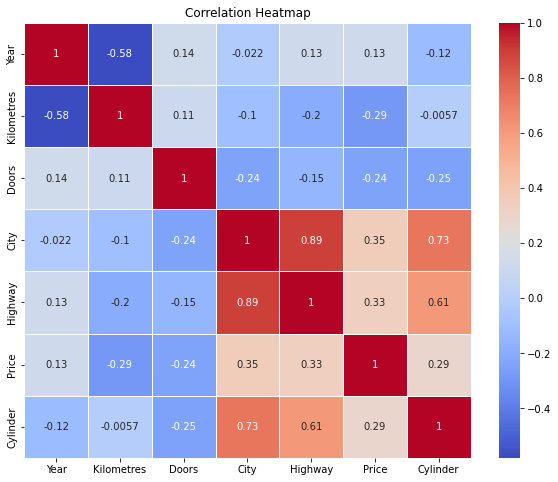

In [28]:
correlation_matrix = used_cars_df.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

#### Kilometers Outliers Removal

In [29]:
kilometres_stats = used_cars_df['Kilometres'].describe()
print(round(kilometres_stats),1)

count      24194.0
mean       69195.0
std        73194.0
min            0.0
25%         7386.0
50%        53600.0
75%       107507.0
max      2470000.0
Name: Kilometres, dtype: float64 1


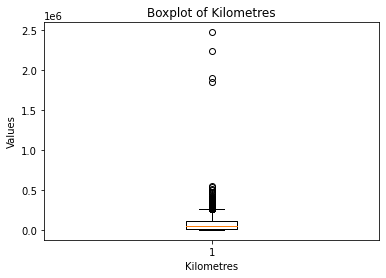

In [30]:
plt.boxplot(used_cars_df['Kilometres'])
plt.xlabel('Kilometres')
plt.ylabel('Values')
plt.title('Boxplot of Kilometres')
plt.show()

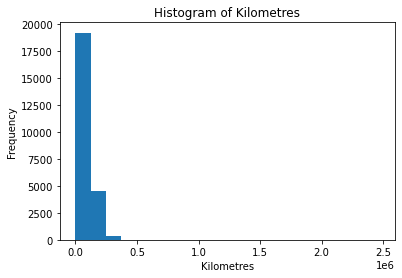

In [31]:
plt.hist(used_cars_df['Kilometres'], bins=20)
plt.xlabel('Kilometres')
plt.ylabel('Frequency')
plt.title('Histogram of Kilometres')
plt.show()

In [32]:
new_cars = used_cars_df[used_cars_df['Kilometres'] == 0]
#new_cars.head(5)

In [33]:
# Calculate the first quartile (Q1) and third quartile (Q3)
km0005 = used_cars_df['Kilometres'].quantile(0.005)
km0995 = used_cars_df['Kilometres'].quantile(0.995)


# Drop the lowest 5% and highest 5% of City and Highway Data
used_cars_df = used_cars_df[(used_cars_df['Kilometres'] >= km0005) & (used_cars_df['Kilometres'] <= km0995)]

#### Highway & City Outlier Removal

In [34]:
highway_stats = used_cars_df['Highway'].describe()
print('Highway Stats:\n', round(highway_stats),1)

print('\n\n')

city_stats = used_cars_df['City'].describe()
print('City Stats:\n', round(city_stats),1)

Highway Stats:
 count    24073.0
mean         8.0
std          2.0
min          3.0
25%          7.0
50%          8.0
75%         10.0
max         43.0
Name: Highway, dtype: float64 1



City Stats:
 count    24073.0
mean        11.0
std          3.0
min          2.0
25%          9.0
50%         11.0
75%         13.0
max         39.0
Name: City, dtype: float64 1


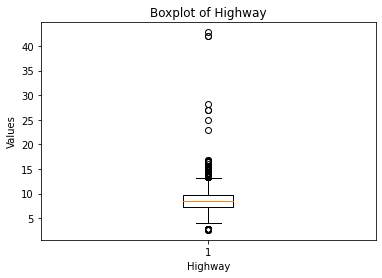

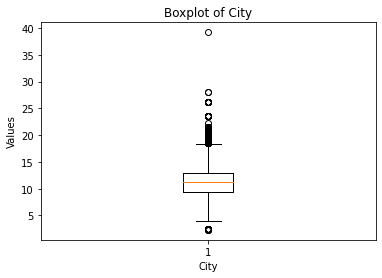

In [35]:
# Boxplot of Highway Column
plt.boxplot(used_cars_df['Highway'])
plt.xlabel('Highway')
plt.ylabel('Values')
plt.title('Boxplot of Highway')
plt.show()

# Boxplot of City Column
plt.boxplot(used_cars_df['City'])
plt.xlabel('City')
plt.ylabel('Values')
plt.title('Boxplot of City')
plt.show()

In [36]:
# Calculate the first quartile (Q1) and third quartile (Q3)
h0005 = used_cars_df['Highway'].quantile(0.005)
h0995 = used_cars_df['Highway'].quantile(0.995)
#print(h0005,h0995)

c0005 = used_cars_df['City'].quantile(0.005)
c0995 = used_cars_df['City'].quantile(0.995)
#print(c0005,c0995)

# Drop the lowest 5% and highest 5% of City and Highway Data
used_cars_df = used_cars_df[(used_cars_df['Highway'] >= h0005) & (used_cars_df['Highway'] <= h0995) & (used_cars_df['City'] >= c0005) & (used_cars_df['City'] <= c0995)]

#### Price Outlier Removal 

In [37]:
price_stats = used_cars_df['Price'].describe()
print('Price Stats:\n', round(price_stats),1)

Price Stats:
 count      23764.0
mean       49125.0
std        69482.0
min          500.0
25%        23888.0
50%        36995.0
75%        59800.0
max      3999998.0
Name: Price, dtype: float64 1


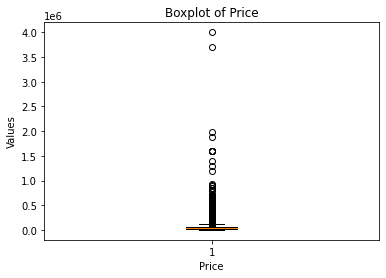

In [38]:
# Boxplot of Price Column
plt.boxplot(used_cars_df['Price'])
plt.xlabel('Price')
plt.ylabel('Values')
plt.title('Boxplot of Price')
plt.show()

In [39]:
price_values = used_cars_df['Price'].values.reshape(-1, 1)
low_range = price_values[np.argsort(price_values, axis=0)[:10]]
high_range = price_values[np.argsort(price_values, axis=0)[-10:]]

# Set the 0.5% and 99.5% quantiles of the distribution
pquan_005 = np.percentile(used_cars_df['Price'], 0.05)
pquan_995 = np.percentile(used_cars_df['Price'], 99.5)
#print(pquan_005, pquan_995)

# Drop the lowest 5% and highest 5% of the price column.
used_cars_df = used_cars_df[(used_cars_df['Price'] >= pquan_005) & (used_cars_df['Price'] <= pquan_995)]

## Exporitory Analysis (EDA)

#### Top Used Car Makes for Sale

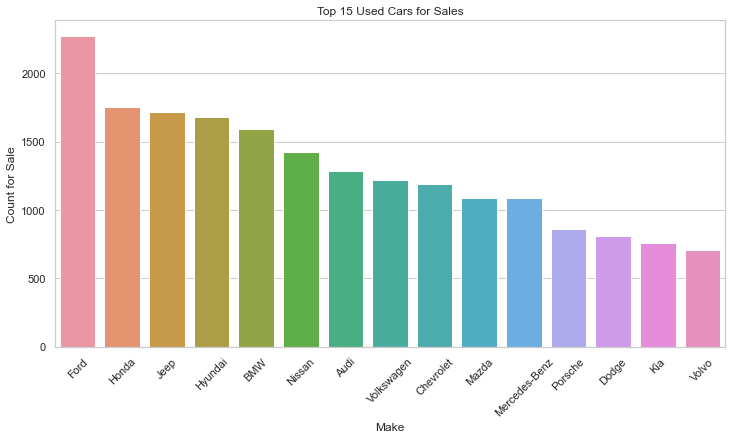

In [40]:
top_15_makes = used_cars_df['Make'].value_counts().head(15)

# Set the plot style
sns.set(style='whitegrid')

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x = top_15_makes.index, y = top_15_makes.values)
plt.title('Top 15 Used Cars for Sales')
plt.xlabel('Make')
plt.ylabel('Count for Sale')
plt.xticks(rotation=45)
plt.show()

#### Type of Drivetrain for Each Make

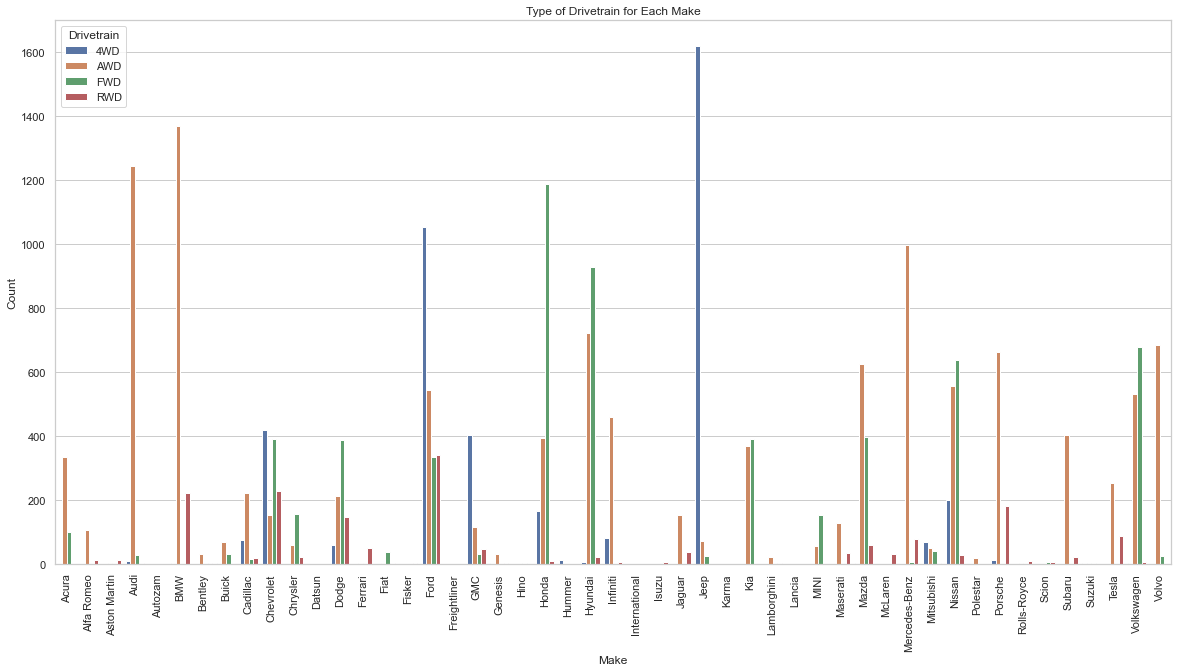

In [41]:
# Group the data by 'Model' and 'Doors' and count the occurrences
make_drivetrain = used_cars_df.groupby(['Make', 'Drivetrain']).size().reset_index(name='Count')

# Set the plot style
sns.set(style='whitegrid')

# Create the bar chart
plt.figure(figsize = (20, 10))
sns.barplot(data = make_drivetrain, x ='Make', y ='Count', hue = 'Drivetrain')
plt.title('Type of Drivetrain for Each Make')
plt.xlabel('Make')
plt.ylabel('Count')
plt.xticks(rotation = 90)
plt.show()

#### Used Car Price Distribution by Top Body Types

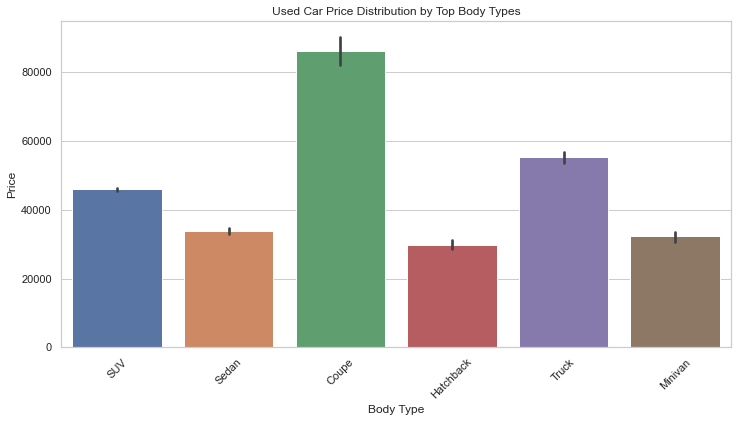

In [42]:
# Set the plot style
sns.set(style = 'whitegrid')

# Filter the DataFrame based on the top six body types
top_6_body_types = used_cars_df['Body Type'].value_counts().head(6).index.tolist()
filtered_df = used_cars_df[used_cars_df['Body Type'].isin(top_6_body_types)]

# Create the bar plot
plt.figure(figsize = (12, 6))
sns.barplot(data = filtered_df, x = 'Body Type', y = 'Price')
plt.title('Used Car Price Distribution by Top Body Types')
plt.xlabel('Body Type')
plt.ylabel('Price')
plt.xticks(rotation = 45)
plt.show()

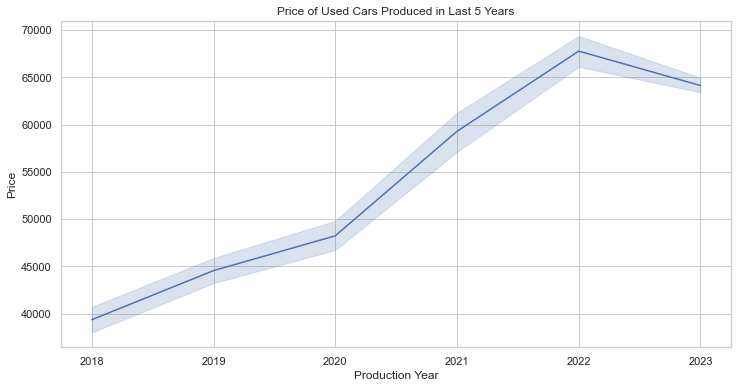

In [43]:
# Filter the DataFrame for the last 5 years used cars.
last_5_years_cars_df = used_cars_df[used_cars_df['Year'] >= used_cars_df['Year'].max() - 5]
#last_5_years_cars_df

# Set the plot style
sns.set(style='whitegrid')

# Create the line plot
plt.figure(figsize = (12, 6))
sns.lineplot(data = last_5_years_cars_df, x = 'Year', y = 'Price')
plt.title('Price of Used Cars Produced in Last 5 Years')
plt.xlabel('Production Year')
plt.ylabel('Price')
plt.show()

In [44]:
# Nomalise the data

# Using Log Transform to make the distribution more symetrical
used_cars_df['Price'] = np.log(used_cars_df['Price'])
# Perform square root transformation for a normal distribution.
used_cars_df['Kilometres'] = boxcox1p(used_cars_df['Kilometres'], boxcox_normmax(used_cars_df['Kilometres'] + 1))
used_cars_df['City'] = boxcox1p(used_cars_df['City'], boxcox_normmax(used_cars_df['City'] + 1))

skewness = used_cars_df[['Price','Kilometres','City','Highway']].skew()
print(skewness)

Price        -0.268144
Kilometres    0.111812
City          0.015411
Highway       0.338172
dtype: float64


## Modeling

#### Split the Model

In [45]:
X = used_cars_df.drop('Price', axis=1)
y = used_cars_df['Price'].values

# Perform one-hot encoding on the categorical columns
X_encoded = pd.get_dummies(X)

# Split data into test and training.
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size = 0.3, random_state = 42)

# Print the shapes of the training and testing sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (16543, 2113) (16543,)
Testing set shape: (7091, 2113) (7091,)


#### Decision Tree Regression

Decision Tree Results:

Mean Squared Error (MSE): 0.059584027622993065
Mean Absolute Error (MAS): 0.1294132817368087
R2 Score: 0.8902970400106884


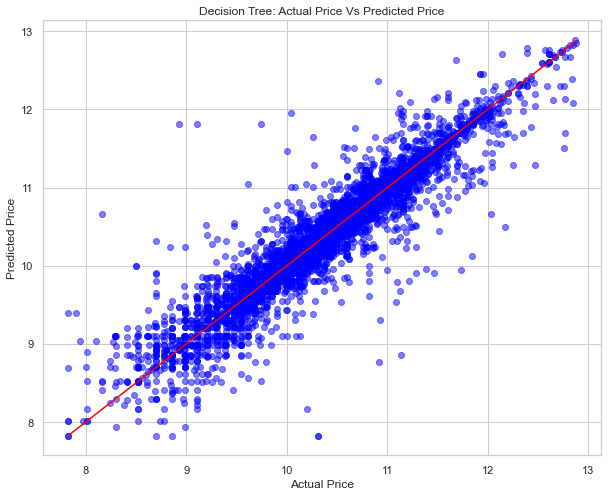

In [46]:
# Fit the decision tree regression model
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = tree.predict(X_test)

# Evaluate the performance of the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print('Decision Tree Results:\n')
print('Mean Squared Error (MSE):', mse)
print('Mean Absolute Error (MAS):', mae)
print('R2 Score:', r2)

# Create a scatter plot with line of best fit
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], color='red')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Decision Tree: Actual Price Vs Predicted Price')
plt.show()


#### Random Forest Regression

Random Forest Regression Results:

Mean Squared Error (MSE): 0.033892766921129615
Mean Absolute Error (MAS): 0.10463184669828397
R2 Score: 0.9375984302873654


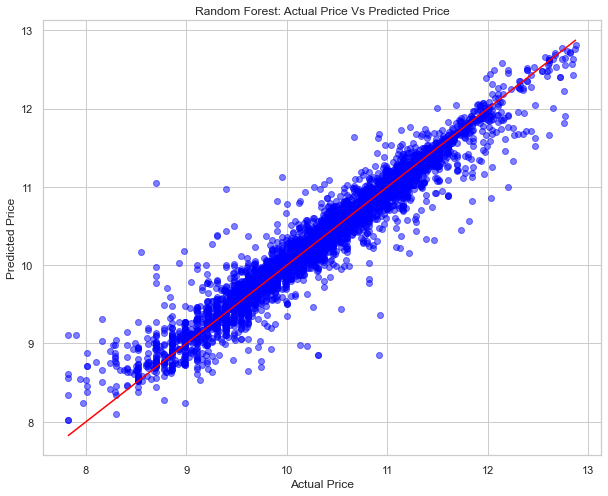

In [47]:
# Create a Random Forest Regression model
rf = RandomForestRegressor()

# Fit the model to the training data
rf.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = rf.predict(X_test)

# Evaluate the performance of the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print('Random Forest Regression Results:\n')
print('Mean Squared Error (MSE):', mse)
print('Mean Absolute Error (MAS):', mae)
print('R2 Score:', r2)

# Create a scatter plot with line of best fit
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], color='red')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Random Forest: Actual Price Vs Predicted Price')
plt.show()


#### Linear Regression - Results are very bad

Linear Regression Results:

Mean Squared Error (MSE): 5400006350374.541
Mean Absolute Error (MAS): 151901.29861979125
R2 Score: -9942206061419.477


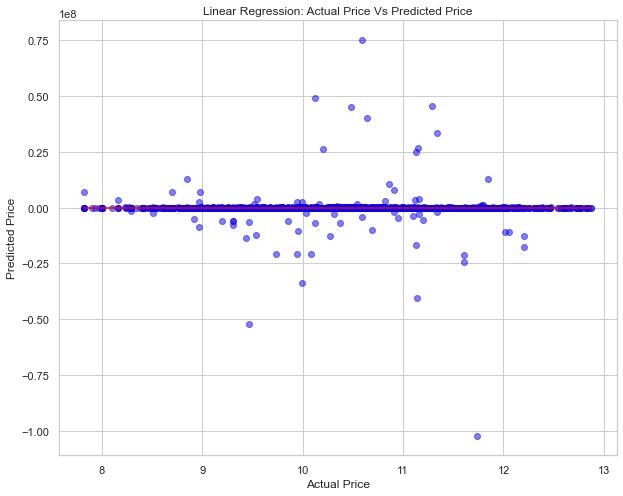

In [48]:
# Create a Linear Regression model
linear_reg = LinearRegression()

# Fit the model on the training data
linear_reg.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = linear_reg.predict(X_test)

# Evaluate the performance of the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print('Linear Regression Results:\n')
print('Mean Squared Error (MSE):', mse)
print('Mean Absolute Error (MAS):', mae)
print('R2 Score:', r2)

# Create a scatter plot with line of best fit
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], color='red')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Linear Regression: Actual Price Vs Predicted Price')
plt.show()
